In [1]:
import numpy as np
import os
import glob
import random
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from PIL import Image 
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import models, transforms
from torch.utils.data import Dataset

c:\Users\HIROYUKI\anaconda3\envs\ai-env\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] 指定されたプロシージャが見つかりません。'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [3]:
# 画像のパスのリストを取得する関数
def get_image_path_list(root_path, phase='train'):
    target_path_jpg = os.path.join(root_path, phase, '**/*.jpg')
    target_path_png = os.path.join(root_path, phase, '**/*.png')
    img_path_list = glob.glob(target_path_jpg) + glob.glob(target_path_png)
    return img_path_list

# root_path = './data/RockPaperScissors'
root_path = './data/RockPaperScissors'
train_list = get_image_path_list(root_path, phase='train')
valid_list = get_image_path_list(root_path, phase='valid')
test_list = get_image_path_list(root_path, phase='test')

print("train image : {} images".format(len(train_list)))
print("valid image : {} images".format(len(valid_list)))
print("test image : {} images".format(len(test_list)))

train image : 2520 images
valid image : 372 images
test image : 33 images


train_list[0] :  ./data/RockPaperScissors\train\paper\paper01-000_png.rf.02152baa06324655efacad9c5bda9f1a.jpg


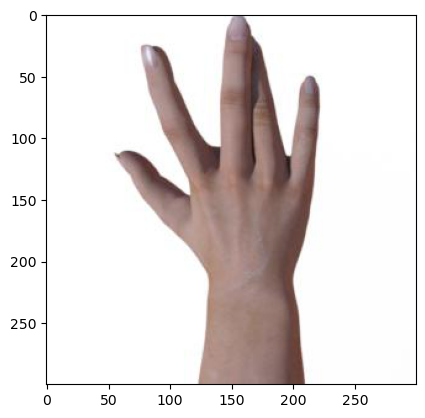

In [6]:
# 訓練サンプルの一つ目
print("train_list[0] : ", train_list[0])
img = Image.open(train_list[0])
plt.imshow(img)
plt.show()

In [7]:
class MyTransform():
    
    def __init__(self, img_size):
        self.data_transform = {
            "train": transforms.Compose([
                transforms.RandomResizedCrop(img_size, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(degrees=10),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
            ]),
            
            "valid": transforms.Compose([
                transforms.Resize(img_size),
                transforms.CenterCrop(img_size),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
            ]),
            
            "test": transforms.Compose([
                transforms.Resize(img_size),
                transforms.CenterCrop(img_size),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
            ])
        }
    
    def __call__(self, img, phase="train"):
        return self.data_transform[phase](img)

(300, 300, 3)


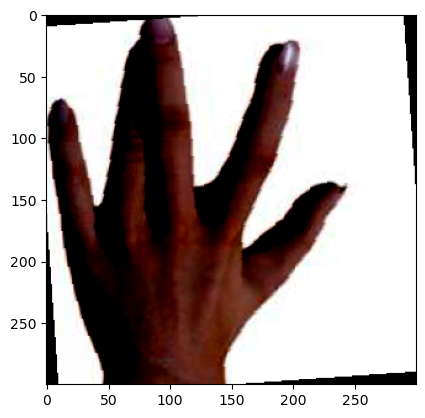

In [8]:
img_size = 300
transform = MyTransform(img_size)
img_transformed = transform(img, phase="train")
img_transformed = img_transformed.numpy().transpose((1,2,0))
img_transformed = np.clip(img_transformed, 0, 1)
print(img_transformed.shape)
plt.imshow(img_transformed)
plt.show()

In [9]:
def show_images(transform=None):
    row = 3
    col = 3
    fig, ax = plt.subplots(nrows=row, ncols=col, figsize=(8,8))
    #img_show_index = [839, 1679, 2519]
    img_show_index = [400, 1200, 2000]
    
    for i, index in enumerate(img_show_index):
        if i==0:
            title="scissors"
        elif i==1:
            title="rock"
        elif i==2:
            title="paper"

        for j in range(row):
            ax[j,i].set_title(title, fontsize=8)
            ax[j,i].axes.xaxis.set_visible(False)
            ax[j,i].axes.yaxis.set_visible(False)
            img = Image.open(train_list[index+(j*10)])
            
            if transform != None:
                img_transformed = transform(img, phase="train")
                img_transformed = img_transformed.numpy().transpose((1,2,0))
                img_transformed = np.clip(img_transformed, 0, 1)
                ax[j,i].imshow(img_transformed)
            else:
                ax[j,i].imshow(img)

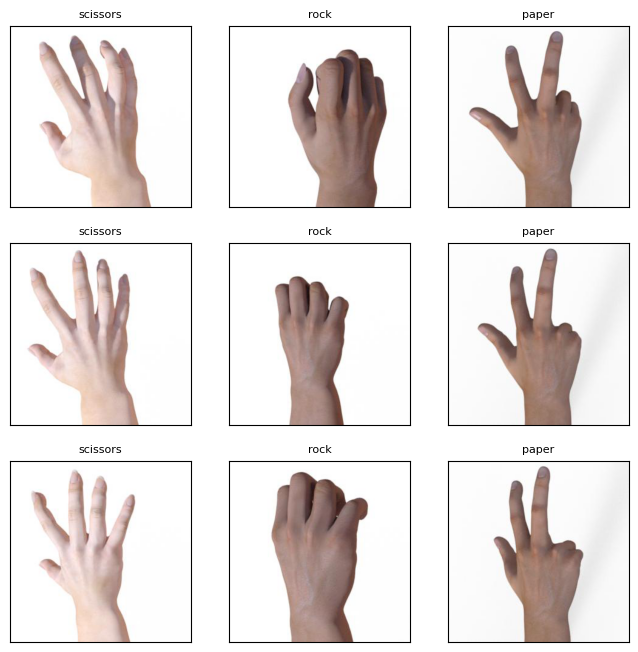

In [10]:
show_images()
plt.savefig('image_show.png')

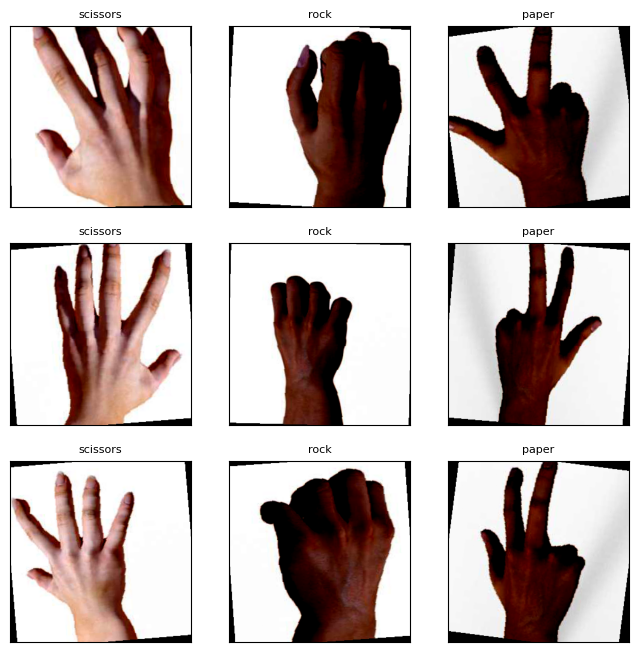

In [11]:
show_images(transform=MyTransform(300))
plt.savefig('image_show_transformed.png')

In [12]:
class RockPaperScissorsDataset(Dataset):
    
    def __init__(self, img_path_list, transform=None, phase='train'):
        self.img_path_list = img_path_list
        self.transform = transform
        self.phase = phase
    
    def __len__(self):
        return len(self.img_path_list)
    
    def __getitem__(self, index):
        # indexの画像の取得
        img_path = self.img_path_list[index]
        img = Image.open(img_path)
        # 前処理された画像の取得
        img_transformed = self.transform(img, phase=self.phase)
        # labelの取得
        label_names = ["rock", "paper", "scissors"]
        for i, name in enumerate(label_names):
            if name in img_path[27:]:
                label = i
        return img_transformed, label

In [14]:
train_dataset = RockPaperScissorsDataset(img_path_list=train_list, transform=MyTransform(img_size=300), phase='train')
valid_dataset = RockPaperScissorsDataset(img_path_list=valid_list, transform=MyTransform(img_size=300), phase='valid')
test_dataset = RockPaperScissorsDataset(img_path_list=test_list, transform=MyTransform(img_size=300), phase='test')

print(train_dataset.__getitem__(0)[0].size())
print(train_dataset.__getitem__(0)[1])

torch.Size([3, 300, 300])
1


In [15]:
batch_size = 16
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

dataloader_dict = {"train": train_dataloader, "valid": valid_dataloader, "test": test_dataloader}

In [16]:
class MyNet(nn.Module):
    def __init__(self, num_classes):
        super(MyNet, self).__init__()
        self.features = nn.Sequential(
	
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=6, stride=2), # in: 300, out: 148
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # in: 148, out: 74
            nn.Dropout(0.5),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1), #in: 74, out: 72
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # in: 72, out: 36
            nn.Dropout(0.5),
            
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1), #in: 36, out: 34
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # in: 34, out: 17
            nn.Dropout(0.5),
            
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=2, stride=1), # in: 17, out: 16
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.5)
        )
        self.classifier = nn.Linear(in_features=8*8*128, out_features=num_classes) 
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [17]:
net = MyNet(num_classes=3)
x = torch.randn(10, 3, 300, 300)
y = net(x)
print(y.size())

torch.Size([10, 3])


In [18]:
# from torchinfo import summary
# summary(net)

ModuleNotFoundError: No module named 'torchinfo'

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=net.parameters(), lr=0.001)

In [20]:
def train(net, dataloader_dict, criterion, optimizer, num_epochs):
    #plot用
    accs = {'train': [], 'valid': []}
    losses = {'train': [], 'valid': []}
    
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    net.to(device)
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch+1, num_epochs))
        
        for phase in ['train', 'valid']:
            if phase=='train':
                net.train()
            elif phase=='valid':
                net.eval()
            epoch_loss = 0.0
            epoch_acc = 0.0
            
            if (epoch==0) and (phase=='train'):
                continue
            
            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                with torch.set_grad_enabled(phase=='train'):
                    optimizer.zero_grad()
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)
                    pred = torch.argmax(outputs, dim=1)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                    epoch_loss += loss.item()
                    epoch_acc += torch.mean(pred.eq(labels).float()) 
     
            epoch_loss /= len(dataloader_dict[phase])
            epoch_acc /= len(dataloader_dict[phase])         
            epoch_acc = epoch_acc.cpu()
	    
            accs[phase].append(epoch_acc)
            losses[phase].append(epoch_loss)
         
            print("{} Loss: {:.4f}, {} accuracy: {:.4f}".format(phase, epoch_loss, phase, epoch_acc))
    return accs, losses

In [ ]:
num_epochs = 200
accs, losses = train(net, dataloader_dict, criterion, optimizer, num_epochs=num_epochs)

In [ ]:
plt.style.use('ggplot')
plt.plot(accs['train'], label='train acc')
plt.plot(accs['valid'], label='validation acc')
plt.legend()
plt.savefig('acc.png')
plt.show()

In [ ]:
plt.style.use('ggplot')
plt.plot(losses['train'], label='train loss')
plt.plot(losses['valid'], label='validation loss')
plt.legend()
plt.savefig('loss.png')
plt.show()

In [ ]:
save_path = './mynet_200epochs.pth'
torch.save(net.state_dict(), save_path)

In [ ]:
def test(net, test_dataloader, criterion):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    net.to(device)
    net.eval()
    
    test_loss = 0.0
    test_corrects = 0.0
    test_preds = []
    test_labels = []
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, dim=1)
            test_preds.extend(preds.tolist())
            test_labels.extend(labels.tolist())
            
            test_loss += loss.item() * inputs.size(0)
            test_corrects += torch.sum(preds==labels.data)
    
    test_loss /= len(test_dataloader.dataset)
    test_corrects /= len(test_dataloader.dataset)
    print("test Loss: {:.4f}, accuracy: {:.4f}".format(test_loss, test_corrects))
    return test_preds, test_labels

In [ ]:
test_preds, test_labels = test(net, test_dataloader, criterion)